**RUNNING AND OPTIMIZING PRO_ANTI**

The definition of the ProAnti network, as well functions to run it and evaluate the cost of a set of runs, get extracted into

    pro_anti.jl
    
At that point we're reaching current development as opposed to stable files.
One cell, an example of running farm F, gets extracted into

    farming.jl
    
    

<h1 id="tocheading">TABLE OF CONTENTS</h1>
<div id="toc"></div>

**Updates to the table of contents are periodic, but run the cell below to first start or force an update.**

In [ ]:
macro javascript_str(s) display("text/javascript", s); end

javascript"""
$.getScript('make_table_of_contents.js')
"""

# ProAnti

In [2]:
#@include_me pro_anti.jl

include("rate_networks.jl")  # that will also include genera_utils.jl, constrained_parabolic_minimization.jl, and hessian_utils.jl


backwardsModel

In [51]:
#@include_me  pro_anti.jl

"""
    plot_PA(t, U, V; fignum=1, clearfig=true, rule_and_delay_period=1, target_period=1, post_target_period=1,
        other_unused_params...)

Helper function for plotting ProAnti results
"""
function plot_PA(t, U, V; fignum=1, clearfig=true, rule_and_delay_period=1, target_period=1, post_target_period=1,
    other_unused_params...)
    figure(fignum)
    if clearfig; clf(); end
    
    ax1 = subplot(3,1,1)
    h = plot(t, V'); 
    setp(h[1], color=[0, 0, 1])
    setp(h[2], color=[1, 0, 0])
    setp(h[3], color=[1, 0.5, 0.5])
    setp(h[4], color=[0, 1, 1])
    ylabel("V")

    ax = gca()
    oldlims = [ylim()[1]+0.1, ylim()[2]-0.1]
    ylim(minimum([V[:];oldlims[1]])-0.1, maximum([V[:];oldlims[2]])+0.1)
    yl = [ylim()[1], ylim()[2]]
    vlines([rule_and_delay_period, 
            rule_and_delay_period+target_period,
            rule_and_delay_period+target_period+post_target_period], 
            -0.05, 1.05, linewidth=2)
    if yl[1]<0.02
        yl[1] = -0.02
    end
    if yl[2]>0.98
        yl[2] = 1.02
    end
    ylim(yl)
    grid(true)
    remove_xtick_labels(ax1)
        
    ax2 = subplot(3,1,2)
    hu = plot(t, U')
    oldlims = [ylim()[1]+0.1, ylim()[2]-0.1]
    ylim(minimum([U[:];oldlims[1]])-0.1, maximum([U[:];oldlims[2]])+0.1)
    setp(hu[1], color=[0, 0, 1])
    setp(hu[2], color=[1, 0, 0])
    setp(hu[3], color=[1, 0.5, 0.5])
    setp(hu[4], color=[0, 1, 1])
    ylabel("U"); 
    vlines([rule_and_delay_period, 
            rule_and_delay_period+target_period,
            rule_and_delay_period+target_period+post_target_period], 
            ylim()[1], ylim()[2], linewidth=2)
    remove_xtick_labels(ax2)

    grid(true)
    
    subplot(3,1,3)
    delta = V[1,:] - V[4,:]
    hr = plot(t, delta)
    oldlims = [ylim()[1]+0.1, ylim()[2]-0.1]
    ylim(minimum([delta[:];oldlims[1]])-0.1, maximum([delta[:];oldlims[2]])+0.1)
    vlines([rule_and_delay_period, 
            rule_and_delay_period+target_period,
            rule_and_delay_period+target_period+post_target_period], 
            ylim()[1], ylim()[2], linewidth=2)
    xlabel("t"); ylabel("Pro R - Pro L")
    grid(true)
        
end



plot_PA

In [4]:
#@include_me  pro_anti.jl

model_params = Dict(
:dt     =>  0.02,    # timestep, in secs
:tau    =>  0.1,     # tau, in ms
:vW     =>  -1.7,    # vertical weight
:hW     =>  -1.7,    # horizontal weight
:sW     =>  0.2,     # self-connection weight
:dW     =>  0,       # diagonal weight
:nsteps =>  2,       # number of timesteps in the simulation
:noise  =>  [],      # noise added during simulation. Can be empty matrix, or an nunits-by-nsteps matrix
:sigma  =>  0.08,    # standard deviation of Gaussian noise added (will be scaled by sqrt(dt) to be relatively dt-INsensitive)
:input  =>  0,       # input current. Can be scalar, nunits-by-1, or nunits-by-nsteps matrix
:g_leak =>  0.25,    # leak conductance
:U_rest =>  -1,      # resting membrane potential
:theta  =>  1,       # inverse slope of g() function
:beta   =>  1,       # offset to g() function
:constant_excitation      => 0.19,   # constant input, added to all units at all timesteps
:anti_rule_strength       => 0.1,    # input added only to anti units during rule_and_delay_period in Anti trials
:pro_rule_strength        => 0.1,    # input added only to pro units during rule_and_delay_period in Pro trials
:const_pro_bias           => 0,      # input added only to pro units during all times in all trial types
:target_period_excitation => 1,      # input added to all units during target_period
:right_light_excitation   => 0.5,    # input added to the Anti and the Pro unit on one side during the target_period
:right_light_pro_extra    => 0,      # input added to the right side Pro unit alone during the target_period
:rule_and_delay_period    => 0.4,    # duration of rule_and_delay_period, in secs
:target_period            => 0.1,    # duration of target_period, in secs
:post_target_period       => 0.5,    # duration of post_target_period, in secs
:const_add => 0,  # from rate_networks.jl, unused here
:init_add  => 0,  # from rate_networks.jl, unused here 
)


function make_input(trial_type; dt=0.02, nderivs=0, difforder=0, constant_excitation=0.19, anti_rule_strength=0.1, 
    pro_rule_strength=0.1, target_period_excitation=1, right_light_excitation=0.5, right_light_pro_extra=0, 
    rule_and_delay_period=0.4, target_period=0.1, post_target_period=0.4, const_pro_bias=0,
    other_unused_params...)

    T = rule_and_delay_period + target_period + post_target_period
    t = 0:dt:T
    nsteps = length(t)

    input = constant_excitation + ForwardDiffZeros(4, nsteps, nderivs=nderivs, difforder=difforder)
    if trial_type=="Anti"
        input[2:3, t.<rule_and_delay_period] += anti_rule_strength
    elseif trial_type=="Pro"
        input[[1,4], t.<rule_and_delay_period] += pro_rule_strength
    else
        error("make_input: I don't recognize input type \"" * trial_type * "\"")
    end
    
    input[:,     (rule_and_delay_period.<=t) & (t.<rule_and_delay_period+target_period)] += target_period_excitation
    input[1:2,   (rule_and_delay_period.<=t) & (t.<rule_and_delay_period+target_period)] += right_light_excitation
    input[1,     (rule_and_delay_period.<=t) & (t.<rule_and_delay_period+target_period)] += right_light_pro_extra
    
    input[[1,4],:] += const_pro_bias
    
    return input, t, nsteps
end


function run_ntrials(nPro, nAnti; plot_list=[], nderivs=0, difforder=0, model_params...)
    pro_input,  t, nsteps = make_input("Pro" ; model_params...)
    anti_input, t, nsteps = make_input("Anti"; model_params...)

    model_params = Dict(model_params)
    sW = model_params[:sW]
    hW = model_params[:hW]
    vW = model_params[:vW]
    dW = model_params[:dW]
    model_params = make_dict(["nsteps", "W"], [nsteps, [sW vW dW hW; vW sW hW dW; dW hW sW vW; hW dW vW sW]], 
        model_params)
    model_params = make_dict(["nderivs", "difforder"], [nderivs, difforder], model_params)
    
    proVs  = ForwardDiffZeros(4, nPro, nderivs=nderivs, difforder=difforder)
    antiVs = ForwardDiffZeros(4, nAnti, nderivs=nderivs, difforder=difforder)

    # --- PRO ---
    if length(plot_list)>0; figure(1); clf(); end
    model_params = make_dict(["input"], [pro_input], model_params)
    for i=1:nPro
        startU = [-0.3, -0.7, -0.7, -0.3]
        Uend, Vend, U, V = forwardModel(startU, do_plot=false; model_params...)
        proVs[:,i] = Vend
        if any(plot_list.==i) 
            plot_PA(t, U, V; fignum=1, clearfig=false, model_params...)
            subplot(3,1,1); title("PRO")
        end
    end

    # --- ANTI ---
    if length(plot_list)>0; figure(2); clf(); end
    model_params = make_dict(["input"], [anti_input], model_params)
    for i=1:nAnti
        startU = [-0.7, -0.3, -0.3, -0.7]
        Uend, Vend, U, V = forwardModel(startU, do_plot=false; model_params...)
        antiVs[:,i] = Vend
        if any(plot_list.==i) 
            plot_PA(t, U, V; fignum=2, clearfig=false, model_params...)
            subplot(3,1,1); title("ANTI")
        end
    end
    
    return proVs, antiVs
end


run_ntrials (generic function with 1 method)

  4.325510 seconds (2.91 M allocations: 123.917 MB, 0.91% gc time)
Pro % correct = 

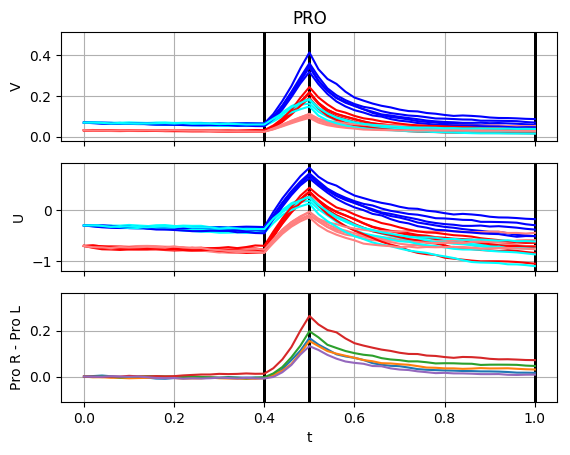

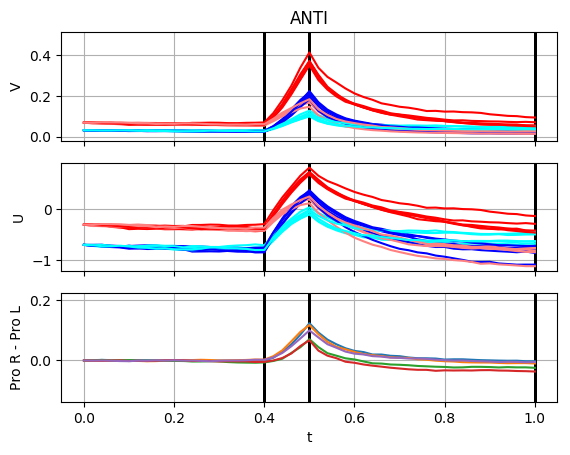

90%
Anti % correct = 100% 


In [5]:
nPro = 10; nAnti = 5;
proVs, antiVs = @time(run_ntrials(nPro, nAnti; plot_list=[1:5;], model_params...))

@printf("Pro %% correct = %g%%\n", 100*length(find(proVs[1,:].>proVs[4,:]))/nPro)
@printf("Anti %% correct = %g%% \n", 100*length(find(antiVs[1,:].<antiVs[4,:]))/nAnti)

## Cost function

Below is a cost function `JJ()` with two terms. Let $C$ be the target fraction "Go Right" trials, and $V_R$ and $V_L$ represent the final value of the $V$ variable for the "Pro Go Right" and "Pro Go Left" units, respectively.

$$
cost_1 = \left( \left\langle \frac{1}{2} + \frac{1}{2}\tanh(\frac{V_R - V_L}{\theta_1}) \right\rangle_{trials} - C \right)^2
$$

In the limit of $\theta_1$ very small, the network's ouput is binarized, decisions go like the sign of $V_R-V_L$, and this cost function is minimized at the desired fraction correct. However, the perfectly binary network is not differentiable. So we keep $\theta1$ smal but non-zero.

To try to make sure that output decisions are clear, we have another component to the cost function

$$
cost_2 = - \left\langle \left( \tanh(\frac{V_R - V_L}{\theta_2}) \right)^2 \right \rangle_{trials}
$$

This component is minimized when the difference between $V_R$ and $V_L$ is large, but if differences are much bigger than $\theta_2$, it stops caring about them.

We've been using a cost function that is a combination of the two:

$$
J_{\rm total} = cost_1 + \beta \cdot cost_2
$$

Meaning our total cost function has three parameters, $\theta_1$, $\theta_2$, and $\beta$, which is a bit of a mess.


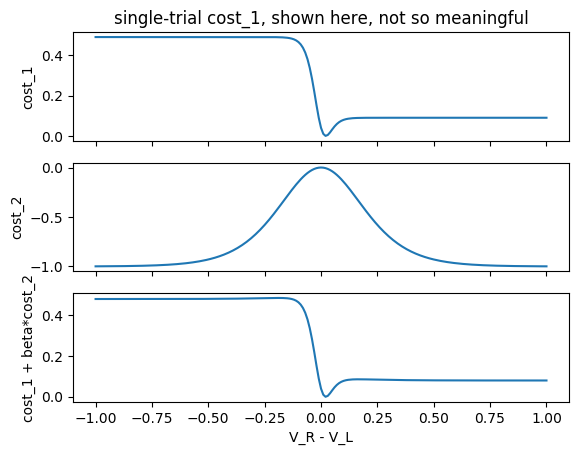

PyObject <matplotlib.text.Text object at 0x32dcdd450>

In [6]:
figure(1); clf();
th1 = 0.05
th2 = 0.25
b   = 0.01
C   = 0.7

p   = 1

vrmvl = -1:0.01:1
cost1 = (0.5 + 0.5*tanh(vrmvl/th1) - C).^2
cost2 = -tanh((vrmvl/th2).^p).^2

ax1 = subplot(3,1,1); plot(vrmvl, cost1)
remove_xtick_labels(ax1)
ylabel("cost_1")
title("single-trial cost_1, shown here, not so meaningful")

ax2 = subplot(3,1,2); plot(vrmvl, cost2)
remove_xtick_labels(ax2)
ylabel("cost_2")

ax3 = subplot(3,1,3); plot(vrmvl, cost1 + b*cost2)
xlabel("V_R - V_L")
ylabel("cost_1 + beta*cost_2")



In [7]:
#@include_me  pro_anti.jl

function JJ(nPro, nAnti; pro_target=0.9, anti_target=0.7, 
    theta1=0.025, theta2=0.035, cbeta=0.003, verbose=false, 
    pre_string="", zero_last_sigmas=0, seedrand=NaN, 
    rule_and_delay_periods = [0.4], target_periods = [0.1], post_target_periods = [0.5],
    nderivs=0, difforder=0, model_params...)

    nruns = length(rule_and_delay_periods)*length(target_periods)*length(post_target_periods)
    
    cost1s = ForwardDiffZeros(1, nruns, nderivs=nderivs, difforder=difforder)
    cost2s = ForwardDiffZeros(1, nruns, nderivs=nderivs, difforder=difforder)

    if ~isnan(seedrand); srand(seedrand); end
    
    n = totHitsP = totHitsA = totDiffsP = totDiffsA = 0
    for i in rule_and_delay_periods
        for j in target_periods
            for k = post_target_periods
                n += 1
                
                my_params = make_dict(["rule_and_delay_period", "target_period", "post_target_period"],
                [i, j, k], Dict(model_params))
    
                # print("model params is " ); print(model_params); print("\n")
                proVs, antiVs = run_ntrials(nPro, nAnti; nderivs=nderivs, difforder=difforder, my_params...)

                hitsP  = 0.5*(1 + tanh.((proVs[1,:]-proVs[4,:,])/theta1))
                diffsP = tanh.((proVs[1,:,]-proVs[4,:])/theta2).^2
                hitsA  = 0.5*(1 + tanh.((antiVs[4,:]-antiVs[1,:,])/theta1))
                diffsA = tanh.((antiVs[4,:,]-antiVs[1,:])/theta2).^2

                if nPro>0 && nAnti>0
                    cost1s[n] = (nPro*(mean(hitsP) - pro_target).^2  + nAnti*(mean(hitsA) - anti_target).^2)/(nPro+nAnti)
                    cost2s[n] = -cbeta*(nPro*mean(diffsP) + nAnti*mean(diffsA))/(nPro+nAnti)
                elseif nPro>0
                    cost1s[n] = (mean(hitsP) - pro_target).^2
                    cost2s[n] = -cbeta*mean(diffsP)
                else
                    cost1s[n] = (mean(hitsA) - anti_target).^2
                    cost2s[n] = -cbeta*mean(diffsA)
                end

                totHitsP  += mean(hitsP);  totHitsA  += mean(hitsA); 
                totDiffsP += mean(diffsP); totDiffsA += mean(diffsA);
            end
        end
    end
    
    cost1 = mean(cost1s)
    cost2 = mean(cost2s)

    hitsP = totHitsP/n; hitsA = totHitsA/n; diffsP = totDiffsP/n; diffsA = totDiffsA/n
    
    if verbose
        @printf("%s", pre_string)
        @printf("     -- cost=%g,   cost1=%g, cost2=%g\n", 
            convert(Float64, cost1+cost2), convert(Float64, cost1), convert(Float64, cost2))
        if nPro>0 && nAnti>0
            @printf("     -- mean(hitsP)=%g, mean(diffsP)=%g mean(hitsA)=%g, mean(diffsA)=%g\n", 
                convert(Float64, mean(hitsP)), convert(Float64, mean(diffsP)),
                convert(Float64, mean(hitsA)), convert(Float64, mean(diffsA)))
        elseif nPro>0
            @printf("     -- mean(hitsP)=%g, mean(diffsP)=%g (nAnti=0)\n", 
                convert(Float64, mean(hitsP)), convert(Float64, mean(diffsP)))
        else
            @printf("     -- (nPro=0) mean(hitsA)=%g, mean(diffsA)=%g\n", 
                convert(Float64, mean(hitsA)), convert(Float64, mean(diffsA)))
        end        
    end
    
    return cost1 + cost2
end

JJ (generic function with 1 method)

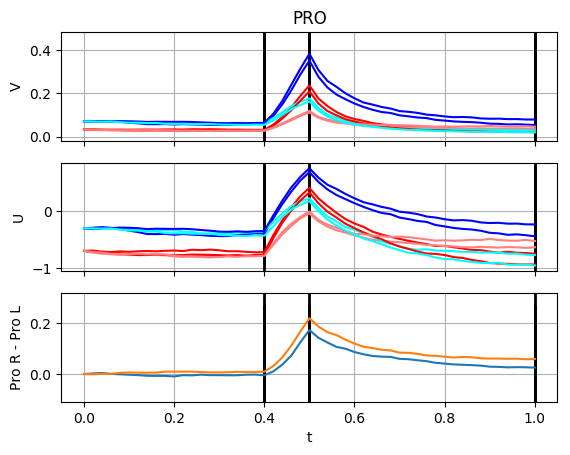

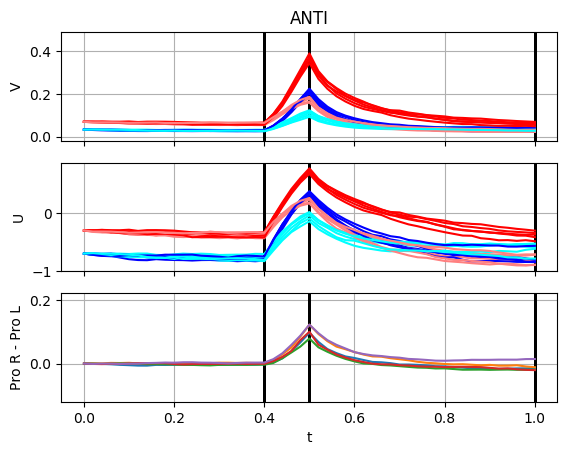

     -- cost=-0.000328553,   cost1=0.000404338, cost2=-0.000732891
     -- mean(hitsP)=0.936041, mean(diffsP)=0.623844 mean(hitsA)=0.684986, mean(diffsA)=0.168388


-0.00032855329523931757

In [8]:
JJ(2, 10; plot_list=1:5, verbose=true, model_params...)

### Example of taking the gradient and Hessian of the cost function JJ()

In [ ]:
args = ["sW", "vW", "hW", "constant_excitation", "right_light_excitation", "target_period_excitation", "const_pro_bias"]
seed = [0.2,   -1.7, -1.7,      0.39,                0.15,                       0.1,                       0.1]

func = (;params...) -> JJ(100, 0; rule_and_delay_periods = [0.4, 0.8], seedrand=30, cbeta=0.01, 
plot_list = 1:5, verbose=false, merge(model_params, Dict(params))...)

cost, grad, hess = keyword_vgh(func, args, seed)

# func(;make_dict(args, seed+ [1,0.2,0,0,0,0,0])...) - func(;make_dict(args, seed)...)


# looking into Alex's farms

In [13]:
include("pro_anti_opto.jl")

forwardModel_opto (generic function with 1 method)

In [55]:
function run_ntrials_opto(nPro, nAnti; plot_list=[], nderivs=0, difforder=0, opto_periods=[-1 -1],model_params...)
    pro_input,  t, nsteps = make_input("Pro" ; model_params...);
    anti_input, t, nsteps = make_input("Anti"; model_params...);

    #### make opto fraction vector
    opto_fraction = make_opto_input(nsteps; nderivs=nderivs,difforder=difforder, model_params...);
    model_params = Dict(model_params)
    sW = model_params[:sW]
    hW = model_params[:hW]
    vW = model_params[:vW]
    dW = model_params[:dW]
    model_params = make_dict(["nsteps", "W"], [nsteps, [sW vW dW hW; vW sW hW dW; dW hW sW vW; hW dW vW sW]], model_params)
    model_params = make_dict(["nderivs", "difforder"], [nderivs, difforder], model_params)
    
    ## include opto fraction in model_params dictionary
    model_params = make_dict(["opto_fraction"], [opto_fraction], model_params);

    proVs  = ForwardDiffZeros(4, nPro, nderivs=nderivs, difforder=difforder)
    antiVs = ForwardDiffZeros(4, nAnti, nderivs=nderivs, difforder=difforder)

    # --- PRO ---
    if length(plot_list)>0; figure(1); clf(); end
    model_params = make_dict(["input"], [pro_input], model_params)
    for i=1:nPro
        startU = [-0.3, -0.7, -0.7, -0.3]
        Uend, Vend, U, V = forwardModel_opto(startU, opto_fraction, do_plot=false; model_params...)
        proVs[:,i] = Vend
        if any(plot_list.==i) 
            plot_PA(t, U, V; fignum=1, clearfig=false, model_params...)
            subplot(3,1,1); title("PRO")
        end
    end

    # --- ANTI ---
    if length(plot_list)>0; figure(2); clf(); end
    model_params = make_dict(["input"], [anti_input], model_params)
    for i=1:nAnti
        startU = [-0.7, -0.3, -0.3, -0.7]
        Uend, Vend, U, V = forwardModel_opto(startU,opto_fraction, do_plot=false; model_params...)
        antiVs[:,i] = Vend
        if any(plot_list.==i) 
            plot_PA(t, U, V; fignum=2, clearfig=false, model_params...)
            subplot(3,1,1); title("ANTI")
        end
    end
    
    return proVs, antiVs
end

function JJ_opto(nPro, nAnti; opto_targets=[0.9 0.7], theta1=0.025, theta2=0.035, cbeta=0.003, 
    verbose=false, pre_string="", zero_last_sigmas=0, seedrand=NaN, 
    rule_and_delay_periods = [0.4], target_periods = [0.1], post_target_periods = [0.5], 
    opto_periods = [-1 -1],opto_strength=1, nderivs=0, difforder=0, 
    plot_conditions = false,
    model_params...) #set opto defaults!

    if ~(size(opto_targets) == size(opto_periods)); error("opto parameters are bad"); end

    nruns = length(rule_and_delay_periods)*length(target_periods)*length(post_target_periods)*size(opto_periods)[1]
    nruns_each = length(rule_and_delay_periods)*length(target_periods)*length(post_target_periods)
    
    cost1s = ForwardDiffZeros(size(opto_periods)[1], nruns_each, nderivs=nderivs, difforder=difforder)
    cost2s = ForwardDiffZeros(size(opto_periods)[1], nruns_each, nderivs=nderivs, difforder=difforder)
    hP = zeros(size(opto_periods)[1], nruns_each);
    hA = zeros(size(opto_periods)[1], nruns_each);
    dP = zeros(size(opto_periods)[1], nruns_each);
    dA = zeros(size(opto_periods)[1], nruns_each);
    hBP = zeros(size(opto_periods)[1], nruns_each);
    hBA = zeros(size(opto_periods)[1], nruns_each);

    n = totHitsP = totHitsA = totDiffsP = totDiffsA =nopto= 0
    for kk=1:size(opto_periods)[1] # iterate over each opto inactivation period
        nopto = 0;

        # reset random number generator for each opto period, so it cant over fit noise samples
        if ~isnan(seedrand); srand(seedrand); end

        for i in rule_and_delay_periods
            for j in target_periods
                for k = post_target_periods
                    nopto += 1

                    # include this opto inactivation in the parameters to pass on
                    my_params = make_dict(["rule_and_delay_period", "target_period", "post_target_period","opto_period","opto_strength"], [i, j, k, opto_periods[kk,:], opto_strength], Dict(model_params))

                    # print("model params is " ); print(model_params); print("\n")
                    if typeof(plot_conditions)==Bool && ~plot_conditions
                        proVs, antiVs = run_ntrials_opto(nPro, nAnti; nderivs=nderivs, difforder=difforder, my_params...)
                    elseif typeof(plot_conditions)==Bool
                        proVs, antiVs = run_ntrials_opto(nPro, nAnti; plot_list=1:10,
                            nderivs=nderivs, difforder=difforder, my_params...)                        
                    elseif plot_conditions[kk]
                        proVs, antiVs = run_ntrials_opto(nPro, nAnti; plot_list=1:10,
                            nderivs=nderivs, difforder=difforder, my_params...)                        
                    else
                        proVs, antiVs = run_ntrials_opto(nPro, nAnti; nderivs=nderivs, difforder=difforder, my_params...)                                                
                    end
                    hitsP  = 0.5*(1 + tanh.((proVs[1,:]-proVs[4,:,])/theta1))
                    diffsP = tanh.((proVs[1,:,]-proVs[4,:])/theta2).^2
                    hitsA  = 0.5*(1 + tanh.((antiVs[4,:]-antiVs[1,:,])/theta1))
                    diffsA = tanh.((antiVs[4,:,]-antiVs[1,:])/theta2).^2

                    # set up storage  
                    hP[kk,nopto] = mean(hitsP);
                    hA[kk,nopto] = mean(hitsA);
                    dP[kk,nopto] = mean(diffsP);
                    dA[kk,nopto] = mean(diffsA);
                    hBP[kk,nopto] = sum(proVs[1,:] .>= proVs[4,:,])/nPro;
                    hBA[kk,nopto] = sum(proVs[4,:] .>  proVs[1,:,])/nAnti;

                    if nPro>0 && nAnti>0
                        cost1s[kk,nopto] = (nPro*(mean(hitsP) - opto_targets[kk,1]).^2  + nAnti*(mean(hitsA) - opto_targets[kk,2]).^2)/(nPro+nAnti)
                        if kk ==1
                        cost2s[kk,nopto] = -cbeta*(nPro*mean(diffsP) + nAnti*mean(diffsA))/(nPro+nAnti)
                        end
                    elseif nPro>0
                        cost1s[kk,nopto] = (mean(hitsP) - opto_targets[kk,1]).^2
                        if kk == 1
                        cost2s[kk,nopto] = -cbeta*mean(diffsP)
                        end
                    else
                        cost1s[kk,nopto] = (mean(hitsA) - opto_targets[kk,2]).^2
                        if kk == 1
                        cost2s[kk,nopto] = -cbeta*mean(diffsA)
                        end
                    end

                  #  totHitsP  += mean(hitsP);  totHitsA  += mean(hitsA); 
                  #  totDiffsP += mean(diffsP); totDiffsA += mean(diffsA);
                end
            end 
        end
    end
    
    cost1 = mean(cost1s)
    cost2 = mean(cost2s)
#    print(cost1s)
    
#    print(cost2s)
#    hitsP = totHitsP/n; hitsA = totHitsA/n; diffsP = totDiffsP/n; diffsA = totDiffsA/n
    
    
#    if verbose
#        @printf("%s", pre_string)
#        @printf("     -- cost=%g,   cost1=%g, cost2=%g\n", 
#            convert(Float64, cost1+cost2), convert(Float64, cost1), convert(Float64, cost2))
#        if nPro>0 && nAnti>0
#            @printf("     -- mean(hitsP)=%g, mean(diffsP)=%g mean(hitsA)=%g, mean(diffsA)=%g\n", 
#                convert(Float64, mean(hitsP)), convert(Float64, mean(diffsP)),
#                convert(Float64, mean(hitsA)), convert(Float64, mean(diffsA)))
#        elseif nPro>0
#            @printf("     -- mean(hitsP)=%g, mean(diffsP)=%g (nAnti=0)\n", 
#                convert(Float64, mean(hitsP)), convert(Float64, mean(diffsP)))
#        else
#            @printf("     -- (nPro=0) mean(hitsA)=%g, mean(diffsA)=%g\n", 
#                convert(Float64, mean(hitsA)), convert(Float64, mean(diffsA)))
#        end        
#    end 
    
    return cost1 + cost2, cost1s, cost2s, hP,hA,dP,dA,hBP,hBA
end



JJ_opto (generic function with 1 method)

In [66]:
G = matread("FarmFields/farm_L0059.mat"); 

In [ ]:
model_params = symbol_key_ize(G["model_params"])

In [96]:
func =  (;params...) -> JJ_opto(model_params[:nPro], model_params[:nAnti]; 
rule_and_delay_periods=G["rule_and_delay_periods"], 
theta1=model_params[:theta1], theta2=model_params[:theta2], 
post_target_periods=G["post_target_periods"], plot_conditions=[false, false, false, true, false],
seedrand=G["sr"], cbeta=G["cb"], verbose=true, 
merge(make_dict(G["args"], G["pars"], merge(model_params, Dict(params))), Dict(:sigma=>0.5))...)


total_cost, cost1s, cost2s, hP,hA,dP,dA,hBP,hBA = func()

[epochs hP hA]

5×3 Array{Any,2}:
 "control"  0.555791  0.52666 
 "full"     0.540776  0.527106
 "rule"     0.546518  0.524981
 "delay"    0.555232  0.528845
 "target"   0.555916  0.529914

In [77]:
[epochs model_params[:opto_targets]]

5×3 Array{Any,2}:
 "control"  0.75  0.73
 "full"     0.77  0.58
 "rule"     0.75  0.74
 "delay"    0.72  0.66
 "target"   0.73  0.75

### above will run one of the farm animals.

In [65]:
# Finding the best farm animal

fnames = filter(x -> startswith(x, "farm_L"), readdir("FarmFields/"))
costs = zeros(size(fnames))
for i=1:length(fnames)
    G = matread("FarmFields/" * fnames[i])
    costs[i] = G["cost"]
end

find(costs .== minimum(costs))

1-element Array{Int64,1}:
 59

In [93]:
merge(make_dict(G["args"], G["pars"], model_params), Dict(:sigma=>0.2))

Dict{Any,Any} with 36 entries:
  :dt                     => 0.02
  :target_period          => 0.1
  :opto_strength          => 0.9688
  :opto_targets           => [0.75 0.73; 0.77 0.58; … ; 0.72 0.66; 0.73 0.75]
  :const_pro_bias         => -0.00124319
  :anti_rule_strength     => 0.1
  :init_add               => 0
  :dW                     => 1.0574
  :sigma                  => 0.2
  :right_light_pro_extra  => 0
  :pro_rule_strength      => 0.1
  :theta2                 => 0.15
  :beta                   => 1
  :vw                     => -1.7
  :sW                     => 3.0
  :vW                     => -0.111964
  :theta                  => 1
  :tau                    => 0.1
  :noise                  => Any[]
  :right_light_excitation => 0.0505701
  :hW                     => -0.325814
  :hw                     => -1.7
  :sw                     => 0.2
  :nAnti                  => 200
  :constant_excitation    => -0.137696
  ⋮                       => ⋮

In [87]:
make_dict(G["args"], G["pars"])

Dict{Any,Any} with 10 entries:
  :constant_excitation      => -0.137696
  :vW                       => -0.111964
  :target_period_excitation => 0.755304
  :opto_strength            => 0.9688
  :const_pro_bias           => -0.00124319
  :right_light_excitation   => 0.0505701
  :hW                       => -0.325814
  :dW                       => 1.0574
  :sigma                    => 0.0117827
  :sW                       => 3.0

In [76]:
epochs = ["control"; "full"; "rule"; "delay"; "target"]

5-element Array{String,1}:
 "control"
 "full"   
 "rule"   
 "delay"  
 "target" 

In [33]:
pygui(true); figure(1)

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x32a31f9d0>)

# mixed_sign_hessian_farm_F_analysis.jl  -- Looking into Hessians with mixed-sign eigenvalues

**RESULT: The mixed-sign Hessian eigenvalues are due to the walls**

There are 122 farm F animals that stopped before their 400-iteration limit.  Of those, if we look at the Hessian for only those parameters that had not reached a bounding wall, all but one farm animal had all-positive eigenvalues (including F_0564). [Thus, for example, for a file in which 2 parameters had reached a bounding wall and 7 parameters had not, we're looking at a 7x7 Hessian.]

The single example with mixed-sign eigenvalues is F_0534. The solution in this farm animal is not terrible, but it ranks as the 203rd best solution out of 751 (27th percentile), far from what we would usually consider. If we took the top 20% solutions we wouldn't even be considering this lone example.

Given that, I think I'm going to proceed working on the assumption that for most files, the walls are the issue; the rare files for which that is not true I propose we just toss, and if those become not rare in the future then I will revisit.

Code: [`mixed_sign_hessian_farm_F_analysis.jl`](http://localhost:8888/edit/mixed_sign_hessian_farm_F_analysis.jl)




In [ ]:
#@include_me   mixed_sign_hessian_farm_F_analysis.jl

"""
walled, free = id_pars_at_walls(bbox, args, pars; tol=1e-3)

Returns a list of elements in pars that are within tol of their bounds described in the bbox Dict(),
and a list of those not within tol of their bounds.  The union of walled and free will be equal to 1:length(pars).

"""
function id_pars_at_walls(bbox, args, pars; tol=1e-3)
    walled = Array{Int}(0)
    free   = Array{Int}(0)
    i = 1; while i<=length(args)
        if typeof(args[i])<:String && haskey(bbox, Symbol(args[i]))
            range = bbox[Symbol(args[i])]
            if any(abs(pars[i]-range).<tol)
                walled = [walled; i]
            else
                free = [free; i]
            end    
        elseif typeof(args[i])<:String
            free = [free; i]
        elseif haskey(bbox, Symbol(args[i][1]))
            range = bbox[Symbol(args[i][1])]
            for j=1:args[i][2]
                if any(abs(pars[i+j-1]-range).<tol)
                    walled = [walled; i+j-1]
                else
                    free = [free; i+j-1]
                end    
            end
            i = i+args[i][2]-1
        else
            for j=1:args[i][2]; free = [free; i+j-1]; end
            i = i+args[i][2]-1
        end
    i=i+1; end    
    
    return walled, free
end


walled, free = id_pars_at_walls(Dict(:a=>[1, 2], :b=>[0.1, 0.2]), ["c", "a", ["b" 2]], [10, 1.9999, 0.1, 0.15])

walled, free = id_pars_at_walls(bbox, args, pars; tol=1e-1)

In [ ]:
#@include_me   mixed_sign_hessian_farm_F_analysis.jl

# ========  This is copied from the code for farm F, telling us how it was run ==============================

# ======= ARGUMENTS AND SEED VALUES:
args = ["sW", "vW", "hW", "dW", "constant_excitation", "right_light_excitation", "target_period_excitation"]
seed = [0.2,   1,   0.2,  1,    0.39,                0.15,                       0.1]

args = [args ; ["const_pro_bias", "sigma"]]
seed = [seed ; [0.1,               0.1]]


# ======= BOUNDING BOX:
bbox = Dict(:sW=>[0 3], :vW=>[-3 3], :hW=>[-3 3], :dW=>[-3 3], :constant_excitation=>[-2 2],
:right_light_excitation=>[0.05 4], :target_period_excitation=>[0.05 4], :const_pro_bias=>[-2 2],
:sigma=>[0.01 0.2])

model_params = merge(model_params, Dict(:post_target_period=>0.5))
# seed = [0.0840597,  -1.32677,  -0.437334,  -0.324835,  0.567997, 0.712216,  0.0500075,  0.0858569,  0.25]


# ======== SEARCH ZONE:

sbox = Dict(:sW=>[0.001 0.5], :vW=>[-0.5 0.5], :hW=>[-0.5 0.5], :dW=>[-0.5 0.5],
:constant_excitation=>[-0.5 0.5], :right_light_excitation=>[0.1 0.5], :target_period_excitation=>[0.1 0.5],
:const_pro_bias=>[0 0.2], :sigma=>[0.02 0.19])

# ========  END  --   This is copied from the code for farm F, telling us how it was run ===================

# Now read all the files to get all there costs and iteration numbers

fnames = filter(x -> startswith(x, "farm_F"), readdir("FarmFields/"))
scosts = zeros(size(fnames))
niters = zeros(size(fnames))
for i=1:length(fnames) 
    A = matread("FarmFields/" * fnames[i])  
    scosts[i] = A["scost"]
    niters[i] = size(A["traj"],2)
end

pygui(true)
figure(1); clf();
plot(scosts, niters, ".")
xlabel("cost at standard beta=0.01")
ylabel("number of iterations run")

In [ ]:
#@include_me   mixed_sign_hessian_farm_F_analysis.jl


# #################  FINALLY TO THE ANALYSIS PART   ################

goodies = find((niters.<400)) #  & (scosts.<-0.007))
mixed_sign = Array{String}(0)

for i=1:length(goodies)
    A = matread("FarmFields/" * fnames[goodies[i]])

    args = A["args"]
    pars = A["pars"]
    nPro = A["nPro"]
    nAnti = A["nAnti"]
    rule_and_delay_periods = A["rule_and_delay_periods"]
    post_target_periods    = A["post_target_periods"]
    theta1 = A["theta1"]
    theta2 = A["theta2"]
    sr = A["sr"]
    cb = A["cb"]
    sbox = symbol_key_ize(A["sbox"])
    bbox = symbol_key_ize(A["bbox"])
    model_params = symbol_key_ize(A["model_params"])


    func =  (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
        theta1=theta1, theta2=theta2,
        post_target_periods=post_target_periods,
        seedrand=sr, cbeta=cb, verbose=false, merge(model_params, Dict(params))...)[1]

    standard_func =  (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
        theta1=theta1, theta2=theta2,
        post_target_periods=post_target_periods,
        seedrand=sr, cbeta=0.01, verbose=false, merge(model_params, Dict(params))...)[1]


    value, grad, hess = keyword_vgh(func, args, pars)

    walled, free = id_pars_at_walls(bbox, args, pars)
    L, V = eig(hess[free,free])
    @printf("%d/%d: file %s had %d free parameters, with hessian eigenvalues ", 
        i, length(goodies), fnames[goodies[i]], length(free))
    print_vector_g(L); print("\n")
    
    if any(L.<0)
        @printf("\n    *** File %s had off-wall mixed sign eigenvalues!\n\n", fnames[goodies[i]])
        mixed_sign = [mixed_sign ; fnames[goodies[i]]]
    end
end



In [ ]:
find(fnames.=="farm_F_0534")
scosts[534]

In [ ]:
A = matread("FarmFields/farm_F_0007")

args = A["args"]
pars = A["pars"]
nPro = A["nPro"]
nAnti = A["nAnti"]
rule_and_delay_periods = A["rule_and_delay_periods"]
post_target_periods    = A["post_target_periods"]
theta1 = A["theta1"]
theta2 = A["theta2"]
sr = A["sr"]
cb = A["cb"]
sbox = symbol_key_ize(A["sbox"])
bbox = symbol_key_ize(A["bbox"])
model_params = symbol_key_ize(A["model_params"])


func =  (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
    theta1=theta1, theta2=theta2,
    post_target_periods=post_target_periods,
    seedrand=sr, cbeta=cb, verbose=true, merge(model_params, Dict(params))...)[1]

standard_func =  (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
    theta1=theta1, theta2=theta2,
    post_target_periods=post_target_periods,
seedrand=sr, cbeta=0.01, verbose=true, merge(model_params, Dict(params))...)[1]


value, grad, hess = keyword_vgh(func, args, pars)


In [ ]:
A = matread("FarmFields/farm_F_0534")

args = A["args"]
pars = A["pars"]
nPro = A["nPro"]
nAnti = A["nAnti"]
rule_and_delay_periods = A["rule_and_delay_periods"]
post_target_periods    = A["post_target_periods"]
theta1 = A["theta1"]
theta2 = A["theta2"]
sr = A["sr"]
cb = A["cb"]
sbox = symbol_key_ize(A["sbox"])
bbox = symbol_key_ize(A["bbox"])
model_params = symbol_key_ize(A["model_params"])


func =  (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
    theta1=theta1, theta2=theta2,
    post_target_periods=post_target_periods,
    seedrand=sr, cbeta=cb, verbose=true, merge(model_params, Dict(params))...)[1]

standard_func =  (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
    theta1=theta1, theta2=theta2,
    post_target_periods=post_target_periods,
seedrand=sr, cbeta=0.01, verbose=true, merge(model_params, Dict(params))...)[1]


value, grad, hess = keyword_vgh(func, args, pars)


In [ ]:
length(find(scosts.<scosts[534]))/length(scosts)

In [ ]:
length(scosts)

In [ ]:
bbox

In [ ]:
A

# Running a ProAnti optimization  

This is the code that ran farm F


In [ ]:
#@include_me   farming.jl

# ======= ARGUMENTS AND SEED VALUES:
args = ["sW", "vW", "hW", "dW", "constant_excitation", "right_light_excitation", "target_period_excitation"]
seed = [0.2,   1,   0.2,  1,    0.39,                0.15,                       0.1]

args = [args ; ["const_pro_bias", "sigma"]]
seed = [seed ; [0.1,               0.1]]


# ======= BOUNDING BOX:
bbox = Dict(:sW=>[0 3], :vW=>[-3 3], :hW=>[-3 3], :dW=>[-3 3], :constant_excitation=>[-2 2],
:right_light_excitation=>[0.05 4], :target_period_excitation=>[0.05 4], :const_pro_bias=>[-2 2],
:sigma=>[0.01 0.2])

model_params = merge(model_params, Dict(:post_target_period=>0.5))
# seed = [0.0840597,  -1.32677,  -0.437334,  -0.324835,  0.567997, 0.712216,  0.0500075,  0.0858569,  0.25]


# ======== SEARCH ZONE:

sbox = Dict(:sW=>[0.001 0.5], :vW=>[-0.5 0.5], :hW=>[-0.5 0.5], :dW=>[-0.5 0.5],
:constant_excitation=>[-0.5 0.5], :right_light_excitation=>[0.1 0.5], :target_period_excitation=>[0.1 0.5],
:const_pro_bias=>[0 0.2], :sigma=>[0.02 0.19])

cbetas = [0.02, 0.04]

fbasename = "FarmFields/farm_F_"

while true
    myseed = seed;
    sr = convert(Int64, round(time()))

    myseed = copy(seed);
    for i=1:length(args)
        sym = Symbol(args[i])
        if haskey(sbox, sym)
            myseed[i] = sbox[sym][1] + diff(sbox[sym],2)[1]*rand()
        end
    end
    nPro=100; nAnti=100

    rule_and_delay_periods = [0.4, 1.2]
    post_target_periods    = [0.5, 1.5]

    theta1 = 0.15; theta2 = 0.25

    for cb in cbetas
        func =  (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
            theta1=theta1, theta2=theta2,
            post_target_periods=post_target_periods,
            seedrand=sr, cbeta=cb, verbose=false, merge(model_params, Dict(params))...)[1]
        
        # And at the standard cb=0.01 for comparison to other cbs
        standard_func =  (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
            theta1=theta1, theta2=theta2,
            post_target_periods=post_target_periods,
            seedrand=sr, cbeta=0.01, verbose=false, merge(model_params, Dict(params))...)[1]        
                
        @printf("Going with seed = "); print_vector_g(myseed); print("\n")
        pars, traj, cost, cpm_traj = bbox_Hessian_keyword_minimization(myseed, args, bbox, func,
            start_eta = 0.01, tol=1e-12, verbose=true, verbose_every=10, maxiter=400)
        @printf("Came out with cost %g and pars = ", cost); print_vector_g(pars); print("\n\n")

        value, grad, hess = keyword_vgh(func, args, pars)
        scost = standard_func(;make_dict(args, pars, model_params)...)
        
        myfilename = next_file(fbasename, 4)

        matwrite(myfilename, Dict("args"=>args, "myseed"=>myseed, "pars"=>pars, "traj"=>traj,
        "cost"=>cost, "cpm_traj"=>cpm_traj, "nPro"=>nPro, "nAnti"=>nAnti, "sr"=>sr, "cb"=>cb,
        "theta1"=>theta1, "theta2"=>theta2,
        "scost"=>scost, "value"=>value, "grad"=>grad, "hess"=>hess,
        "model_params"=>ascii_key_ize(model_params), "bbox"=>ascii_key_ize(bbox), "sbox"=>ascii_key_ize(sbox),
        "rule_and_delay_periods"=>rule_and_delay_periods, "post_target_periods"=>post_target_periods))

    end
end


# Alex's farm G

In [ ]:
#@include_me alex_farm_g0011.jl

include("pro_anti.jl")

A = matread("FarmFields/farm_G_1.mat0011")

model_params = symbol_key_ize(A["model_params"])
for k in keys(A); print(k); print("  "); end

A

In [ ]:
[args[:]  A["myseed"]]

In [ ]:
#@include_me alex_farm_g0011.jl

bbox = Dict(:sW=>[0 3], :vW=>[-3 3], :hW=>[-3 3], :dW=>[-3 3], :constant_excitation=>[-2 2],
:right_light_excitation=>[0.05 4], :target_period_excitation=>[0.05 4], :const_pro_bias=>[-2 2],
:sigma=>[0.01 0.2]);

model_params = symbol_key_ize(A["model_params"])

    rule_and_delay_periods = [0.4, 1.2]
    post_target_periods    = [0.5, 1.5]

    standard_func =  (;params...) -> JJ(model_params[:nPro], model_params[:nAnti]; 
    rule_and_delay_periods=rule_and_delay_periods, theta1=model_params[:theta1], theta2=model_params[:theta2], 
    post_target_periods=post_target_periods,  seedrand=A["sr"], cbeta=0.01, verbose=true, 
    merge(model_params, Dict(params))...)[1]        

value, grad, hess = keyword_vgh(standard_func, A["args"], A["myseed"])


In [ ]:
#@include_me alex_farm_g0011.jl

pars, traj, cost, cpm_traj = bbox_Hessian_keyword_minimization(A["myseed"], A["args"], bbox, standard_func,
        start_eta = 0.03, tol=1e-18, verbose=true, verbose_every=1, maxiter=4000)


In [ ]:
traj

In [ ]:

fnames = readdir("FarmFields/")
for f in filter(x -> startswith(x, "farm_G_1.mat"), readdir("FarmFields/"))

    A = matread("FarmFields/" * f)
    model_params = symbol_key_ize(A["model_params"])

    rule_and_delay_periods = [0.4, 1.2]
    post_target_periods    = [0.5, 1.5]

    standard_func =  (;params...) -> JJ(model_params[:nPro], model_params[:nAnti]; 
    rule_and_delay_periods=rule_and_delay_periods, theta1=model_params[:theta1], theta2=model_params[:theta2], 
    post_target_periods=post_target_periods,  seedrand=A["sr"], cbeta=0.01, verbose=true, 
    merge(model_params, Dict(params))...)[1]        

    standard_func(;make_dict(A["args"], A["pars"])...)

    @printf("File %s, niters was %d\n\n", f, size(A["traj"],2))
end

# Sandbox -- the in flux crazy wilds from here on

various things in progress

In [ ]:
next_file("FarmFields/farm_E_", 4)

In [ ]:
"""
cost = standard_cost(args, pars, sr, model_params)

Computes the cost as if cb had been 0.01 and theta1=0.15 and theta2=0.25
"""
function standard_cost(args, pars, sr, model_params)
    cb = 0.01
    theta1 = 0.15
    theta2 = 0.25
    nPro=100; nAnti=100

    rule_and_delay_periods = [0.4, 1.2]
    post_target_periods    = [0.5, 1.5]

    func = (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
            post_target_periods=post_target_periods,
            theta1=theta1, theta2=theta2, 
            seedrand=sr, cbeta=cb, verbose=false, merge(model_params, Dict(params))...)
    
    return func(;make_dict(args, pars)...)
end
    
"""
cost = standard_cost(filename)

Returns the standard cost (at cb=0.01, theta1=0.15, theta2=0.25) and inserts it into the file with 
key "scost2" if it wasn't there already
"""
function standard_cost(filename; verbose=false)
    A = matread(filename)
    if !haskey(A, "scost2")
        get!(A, "scost2", standard_cost(A["args"], A["pars"], A["sr"], symbol_key_ize(A["model_params"])))
        if verbose
            @printf("File %s did not have scost, adding its value %g\n", filename, A["scost"])
        end
        matwrite(filename, A)
    end
    return A["scost"]
end

#####################################


"""
value, grad, hess = standard_vgh(args, pars, sr, model_params)

Computes the value, gradient, and hessian as if cb had been 0.01 and theta1=0.15 and theta2=0.25
"""
function standard_vgh(args, pars, sr, model_params; theta1=0.025, theta2=0.035)
    cb = 0.01
    nPro=100; nAnti=100

    rule_and_delay_periods = [0.4, 1.2]
    post_target_periods    = [0.5, 1.5]

    func = (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
            post_target_periods=post_target_periods,
            theta1=theta1, theta2=theta2, 
            seedrand=sr, cbeta=cb, verbose=false, merge(model_params, Dict(params))...)

    value, grad, hess = keyword_vgh(func, args, pars)
    
    return value, grad, hess
end

func = (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods, verbose=true,
            post_target_periods=post_target_periods,
            theta1=theta1, theta2=theta2,
            seedrand=sr, cbeta=cb, verbose=false, merge(my_params, Dict(params))...)[1]


"""
value, grad, hess = standard_vgh(filename)

Returns the standard cost (at cb=0.01, theta1=0.15, theta2=0.25), gradient, and hessian
and inserts them into the file with key "scost2", "grad" and "hess" if they weren't there already
"""
function standard_vgh(filename; verbose=false, force=false)
    A = matread(filename)
    if !haskey(A, "theta1"); get!(A, "theta1", 0.025); end
    if !haskey(A, "theta2"); get!(A, "theta2", 0.035); end
    if !haskey(A, "rule_and_delay_periods"); get!(A, "rule_and_delay_periods", [0.4, 1.2]); end;
    if !haskey(A, "post_target_periods");    get!(A, "post_target_periods",    [0.5, 1.5]); end;
      
    if force || !haskey(A, "value") || !haskey(A, "grad")  || !haskey(A, "hess")
        value, grad, hess = standard_vgh(A["args"], A["pars"], A["sr"], 
        symbol_key_ize(A["model_params"]); theta1=A["theta1"], theta2=A["theta2"]) 
        if !haskey(A, "value"); get!(A, "value", value); else A["value"] = value; end;
        if !haskey(A, "grad"); get!(A, "grad", grad); else A["grad"] = grad; end;
        if !haskey(A, "hess"); get!(A, "hess", hess); else A["hess"] = hess; end;
        if verbose
            @printf("File %s did not have value or grad or hess, adding its value %g\n", filename, A["value"])
        end
        matwrite(filename, A)
    end
    return A["value"], A["grad"], A["hess"]
end



In [ ]:
# A = matread("FarmFields/farm_E_0001")
# value, grad, hess = standard_vgh(A["args"], A["pars"], A["sr"], symbol_key_ize(A["model_params"]))
standard_vgh("FarmFields/farm_A_0001"; verbose=true, force=true)
A = matread("FarmFields/farm_A_0001")


In [ ]:
eval(Symbol("hess"))

In [ ]:
standard_vgh("FarmFields/farm_A_0001", verbose=true)
A = matread("FarmFields/farm_A_0001")
A

In [ ]:
A = matread("farm_A_0001")
@printf("At cb=0.002, cost was %g. At cb=0.01, cost was %g\n", A["cost"], standard_cost("farm_A_0001"))


### Run the next three cells, in sequence, to see results of an individual farm animal and to see computation of gradient and hessian of the result

In [ ]:
A = matread("FarmFields/farm_G_1.mat0001")
model_params = symbol_key_ize(A["model_params"])
args         = A["args"];
nAnti        = A["nAnti"]
nPro         = A["nPro"]
pars         = A["pars"]
sr           = A["sr"]
traj         = A["traj"]
cpm_traj     = A["cpm_traj"]
cb           = A["cb"]
theta1       = A["theta1"]
theta2       = A["theta2"]
rule_and_delay_periods = A["rule_and_delay_periods"]
post_target_periods    = A["post_target_periods"]


@printf("Cost went from %g to %g (at standard beta=0.01, cost ended at %g); max iters on cpm was %d\n\n", 
traj[2,1], traj[2,end], A["scost"], maximum(cpm_traj[1,:]))

A

In [ ]:
good_seed = [0.0840597,  -1.32677,  -0.437334,  -0.324835,  0.567997, 0.712216,  0.0500075,  0.0858569,  0.25]

[args pars good_seed]

In [ ]:
# --------------------
# NOW EVALUATE RESULTS HERE
# --------------------

my_params = make_dict([args; "plot_list"; "post_target_period"; "rule_and_delay_period"; "dt"], 
[pars; [[1:10;]]; 0.2; 0.4; 0.02], model_params)

run_factor = 2

proVs, antiVs = @time(run_ntrials(nPro*run_factor, nAnti*run_factor; plot_list=[], my_params...))

if nPro>0;  @printf("Pro %% correct = %g%%\n", 100*length(find(proVs[1,:].>proVs[4,:]))/(nPro*run_factor)); end;
if nAnti>0; @printf("Anti %% correct = %g%% \n", 100*length(find(antiVs[1,:].<antiVs[4,:]))/(nAnti*run_factor)); end;


figure(3); clf();
ax1 = subplot(2,1,1)
h = plt[:hist](proVs[1,:]-proVs[4,:],-1:0.02:1)
title("PRO Vr - Vl")
remove_xtick_labels(ax1)
vlines(0, ylim()[1], ylim()[2])

ax2 = subplot(2,1,2)
h = plt[:hist](antiVs[1,:]-antiVs[4,:],-1:0.02:1)
title("ANTI Vr - Vl")
vlines(0, ylim()[1], ylim()[2])

figure(1); clf(); figure(2); clf();

JJ(nPro, nAnti; verbose=true, seedrand=sr, rule_and_delay_periods=my_params[:rule_and_delay_period], 
post_target_periods=my_params[:post_target_period], my_params...)


# A function that takes only keyword-value pairs and returns a scalar. Its default parameter values are the result
# of the farm (as put into my_params, which hold the farm's output)
func = (;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods, verbose=true,
            post_target_periods=post_target_periods,
            theta1=theta1, theta2=theta2,
            seedrand=sr, cbeta=cb, verbose=false, merge(my_params, Dict(params))...)[1]

# keyword_vgh takes that kind of function
cost, grad, hess = keyword_vgh(func, args, pars)



In [ ]:
traj[:,end]

### Evaluating the results across many farm animals

In [ ]:
basename = "farm_G_1.mat"
fnames = readdir("FarmFields")
matched_filenames = Array{Bool}(length(fnames))
for i=1:length(fnames)
    matched_filenames[i] = ismatch(Regex(@sprintf("^%s", basename)), fnames[i])
end
myguys = fnames[find(matched_filenames)]
costs  = zeros(size(myguys))
cbs    = zeros(size(myguys))
nsteps = zeros(size(myguys)) 
for i=1:length(myguys)
    A = matread("FarmFields/" * myguys[i])
    costs[i]  = A["cost"] # standard_cost(myguys[i]; verbose=true)
    cbs[i]    = A["cb"]
    nsteps[i] = size(A["traj"],2)
end


cbset = unique(cbs)

figure(3); clf();
for i=1:length(cbset)    
    ax1 = subplot(length(cbset),1,i)
    h1 = plt[:hist](costs[find(cbs.==cbset[i])]) # , -0.02:0.001:0.008);
    ylabel("# of runs")
    title(@sprintf("cb=%g  (%d total)", cbset[i], length(find(cbs.==cbset[i]))))
    if i < length(cbset)
        remove_xtick_labels(ax1)
    end
    if i==length(cbset)
        xlabel("final cost")
    end
end
        
unique(cbs)

In [ ]:
figure(3); clf()
plt[:hist](nsteps, 0:2:400);

In [ ]:
A = matread("FarmFields/farm_G_1.mat0001")

# Example of 9-param, including diagonal weight and sigma, and robust across 3x in rule/delay period and post-target period

In [ ]:
args = ["sW", "vW", "hW", "constant_excitation", "right_light_excitation", "target_period_excitation", "sigma"]
seed = [0.2,   -1.7, -1.7,      0.19,                0.5,                       1,                       0.1]
seed = [0.2,   0.17,  0.17,      0.19,                0.5,                       1,                       0.1]
seed = [0.2,   -1.7, -1.7,      -0.19,                0.5,                       1,                       0.1]
seed = [0.2,   -1.7, -1.7,      0.39,                0.15,                       0.1,                     0.1]
bbox = Dict(:sW=>[0 3], :vW=>[-3 3], :hW=>[-3 3], :constant_excitation=>[-2 2],
:right_light_excitation=>[0.05 4], :target_period_excitation=>[0.05 4], :sigma=>[0.05 1])
model_params = merge(model_params, Dict(:post_target_period=>0.5))


# Now with constant_pro_bias and a fixed sigma=0.1
args = ["sW", "vW", "hW", "dW", "constant_excitation", "right_light_excitation", "target_period_excitation"]
seed = [0.2,   -1.7, -1.7,  0,    0.39,                0.15,                       0.1]
args = [args ; ["const_pro_bias", "sigma"]]
seed = [seed ; [0.1,               0.1]]
model_params = merge(model_params, Dict(:post_target_period=>0.5))
bbox = Dict(:sW=>[0 3], :vW=>[-3 3], :hW=>[-3 3], :dW=>[-3 3], :constant_excitation=>[-2 2],
:right_light_excitation=>[0.05 4], :target_period_excitation=>[0.05 4], :const_pro_bias=>[-2 2],
:sigma=>[0.01 0.25])

# seed = [0.0840597,  -1.32677,  -0.437334,  -0.324835,  0.567997, 0.712216,  0.0500075,  0.0858569,  0.25]

# ==========

nPro=100; nAnti=100

rule_and_delay_periods = [0.4, 1.2]
post_target_periods    = [0.5, 1.5]

pars, traj, cost, cpm_traj = bbox_Hessian_keyword_minimization(seed, args, bbox, 
(;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
post_target_periods=post_target_periods,
seedrand=31, cbeta=0.01, verbose=true, merge(model_params, Dict(params))...),
start_eta = 0.01, tol=1e-9, verbose=true)

pars'

In [ ]:
[args pars]

In [ ]:
# --------------------
# NOW EVALUATE RESULTS HERE
# --------------------

my_params = make_dict([args; "plot_list"; "post_target_period"; "rule_and_delay_period"; "dt"], 
[pars; [[1:10;]]; 1.5; 1; 0.01], model_params)

run_factor = 10

proVs, antiVs = @time(run_ntrials(nPro*run_factor, nAnti*run_factor; plot_list=[], my_params...))

if nPro>0;  @printf("Pro %% correct = %g%%\n", 100*length(find(proVs[1,:].>proVs[4,:]))/(nPro*run_factor)); end;
if nAnti>0; @printf("Anti %% correct = %g%% \n", 100*length(find(antiVs[1,:].<antiVs[4,:]))/(nAnti*run_factor)); end;


figure(3); clf();
ax1 = subplot(2,1,1)
h = plt[:hist](proVs[1,:]-proVs[4,:],-1:0.02:1)
title("PRO Vr - Vl")
remove_xtick_labels(ax1)
vlines(0, ylim()[1], ylim()[2])

ax2 = subplot(2,1,2)
h = plt[:hist](antiVs[1,:]-antiVs[4,:],-1:0.02:1)
title("ANTI Vr - Vl")
vlines(0, ylim()[1], ylim()[2])

figure(1); clf(); figure(2); clf();

JJ(nPro, nAnti; rule_and_delay_periods=my_params[:rule_and_delay_period], 
post_target_periods=my_params[:post_target_period], my_params...)


# Example of a ProAnti network optimization

This one uses two rule periods and two post_target_periods to try to get some stability in the trained network.

In [ ]:
args = ["sW", "vW", "hW", "constant_excitation", "right_light_excitation", "target_period_excitation", "sigma"]
seed = [0.2,   -1.7, -1.7,      0.19,                0.5,                       1,                       0.1]
seed = [0.2,   0.17,  0.17,      0.19,                0.5,                       1,                       0.1]
seed = [0.2,   -1.7, -1.7,      -0.19,                0.5,                       1,                       0.1]
seed = [0.2,   -1.7, -1.7,      0.39,                0.15,                       0.1,                       0.1]
bbox = Dict(:sW=>[0 3], :vW=>[-3 3], :hW=>[-3 3], :constant_excitation=>[-2 2],
:right_light_excitation=>[0.05 4], :target_period_excitation=>[0.05 4], :sigma=>[0.05 1])
model_params = merge(model_params, Dict(:post_target_period=>0.5))


# Now with constant_pro_bias and a fixed sigma=0.1
args = ["sW", "vW", "hW", "constant_excitation", "right_light_excitation", "target_period_excitation", "const_pro_bias"]
seed = [0.2,   -1.7, -1.7,      0.39,                0.15,                       0.1,                       0.1]
model_params = merge(model_params, Dict(:post_target_period=>0.5, :sigma=>0.1))
bbox = Dict(:sW=>[0 3], :vW=>[-3 3], :hW=>[-3 3], :constant_excitation=>[-2 2],
:right_light_excitation=>[0.05 4], :target_period_excitation=>[0.05 4], :const_pro_bias=>[-2 2])

# ==========

nPro=100; nAnti=100

rule_and_delay_periods = [0.4, 0.8]
post_target_periods    = [0.5, 1]

pars, traj, cost, cpm_traj = bbox_Hessian_keyword_minimization(seed, args, bbox, 
(;params...) -> JJ(nPro, nAnti; rule_and_delay_periods=rule_and_delay_periods,
post_target_periods=post_target_periods,
seedrand=31, cbeta=0.01, verbose=true, merge(model_params, Dict(params))...),
start_eta = 0.01, tol=1e-12, verbose=true, maxiter=2)

pars'

In [ ]:
cost

In [ ]:
# --------------------
# NOW EVALUATE RESULTS HERE
# --------------------

my_params = make_dict([args; "plot_list"; "post_target_period"; "rule_and_delay_period"; "dt"], 
[pars; [[1:10;]]; 1.5; 0.5; 0.02], model_params)

run_factor = 10

proVs, antiVs = @time(run_ntrials(nPro*run_factor, nAnti*run_factor; plot_list=[], my_params...))

if nPro>0;  @printf("Pro %% correct = %g%%\n", 100*length(find(proVs[1,:].>proVs[4,:]))/(nPro*run_factor)); end;
if nAnti>0; @printf("Anti %% correct = %g%% \n", 100*length(find(antiVs[1,:].<antiVs[4,:]))/(nAnti*run_factor)); end;


figure(3); clf();
ax1 = subplot(2,1,1)
h = plt[:hist](proVs[1,:]-proVs[4,:],-1:0.02:1)
title("PRO Vr - Vl")
remove_xtick_labels(ax1)
vlines(0, ylim()[1], ylim()[2])

ax2 = subplot(2,1,2)
h = plt[:hist](antiVs[1,:]-antiVs[4,:],-1:0.02:1)
title("ANTI Vr - Vl")
vlines(0, ylim()[1], ylim()[2])

figure(1); clf(); figure(2); clf();

JJ(nPro, nAnti; rule_and_delay_periods=my_params[:rule_and_delay_period], 
post_target_periods=my_params[:post_target_period], my_params...)


In [ ]:
######################################################
#                                                    #
#         BBOX_HESSIAN_KEYWORD_MINIMIZATION          #
#                                                    #
######################################################




"""
pdict = wallwrap(bdict, pdict)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, and pdict, a dictionary of symbols
to values (or, alternatively, an Array of (Symbol, value) tuples], goes through each of the symbols in 
bdict and modifies the corresponding value in pdict putting it through a tanh so the final output lies 
within the limits in bdict.  Returns the new pdict.  Makes a copy of pdict so as not to modify the original.
"""
function wallwrap(bdict, epdict)
    local pdict = two_level_copy(epdict)
    if typeof(pdict)<:Array
        pdict = Dict(pdict)
    end

    allkeys = keys(bdict)

    for k in allkeys
        local bbox = bdict[k]
        d = 0.5*(bbox[2] - bbox[1])
        m = 0.5*(bbox[2] + bbox[1])

        pdict[k] = bbox[1] + d*(tanh((pdict[k]-m)/d)+1)
    end
    return pdict
end

    
"""
params = vector_wrap(bbox, args, eparams)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, args, an array of strings representing
symbols, and params, an array of values corresponding to the args list, puts each param that has an entry 
in bdict through the tanh-walling mechanism, and returns the result. Does not modify the contents of the 
original params vector (or bdict or args).
"""
function vector_wrap(bbox, args, eparams)
    local params = two_level_copy(eparams)
    pdict = wallwrap(bbox, make_dict(args, params))
    i=1; j=1
    for i=1:length(args)
        if typeof(args[i])<:Array
            params[j:j+args[i][2]-1] = pdict[Symbol(args[i][1])]
            j += args[i][2]-1
        else
            params[j] = pdict[Symbol(args[i])]
        end
    j = j+1
    end
    return params
end


"""
params = inverse_wall(bdict, args, wparams)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, args, an array of strings representing
symbols, and wparams, an array of values corresponding to the args list where each param that has an entry 
in bdict has alreadt been through the tanh-walling mechanism, UNwalls the ones that have a bdict entry and
returns the result. Does not modify the contents of the original params vector (or bdict or args).
"""
function inverse_wall(bdict, args, wparams)
    local params = two_level_copy(wparams)
    pdict = inverse_wall(bdict, make_dict(args, params))
    i=1; j=1
    for i=1:length(args)
        if typeof(args[i])<:Array
            params[j:j+args[i][2]-1] = pdict[Symbol(args[i][1])]
            j += args[i][2]-1
        else
            params[j] = pdict[Symbol(args[i])]
        end
        j = j+1
    end
    return params    
end

    
"""
pdict = inverse_wall(bdict, wdict)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, and wdict, a dictionary of symbols to values
(or vectors of values)  UNwalls the ones that have a bdict entry and
returns the result. Does not modify the contents of any dictionaries.
"""
function inverse_wall(bdict, wdict)
    local pdict = two_level_copy(wdict)

    allkeys = keys(bdict)
    for k in allkeys
        local bbox = bdict[k]
        d = 0.5*(bbox[2] - bbox[1])
        m = 0.5*(bbox[2] + bbox[1])

        try
            pdict[k] = m + d*0.5*log((pdict[k]-bbox[1])./(2*d - pdict[k] + bbox[1]))
        catch
            error(@sprintf("Had trouble with key %s", string(k)))
        end
    end
    return(pdict)
end
  


"""
function bbox_Hessian_keyword_minimization(seed, args, bbox, func; wallwidth=NaN, start_eta=10, tol=1e-6, 
    maxiter=400, verbose=false)

Like constrained_Hessian_minimization, but uses keyword_hessian!(). 

# PARAMETERS:

- seed        column vector, representing the starting value of the parameters.

- args        List of strings identifying parameters for differentiation, e.g., ["const_E", "w_self]

- bbox        If softbox=true (the default), should then be a Dict of Symbol=>[minval maxval] entries. An entry
            in this Dict indicates that the corresponding parameter is to be bounded, as indicated by the associated 
            [minval maxval] vector. The bbox dictionary can have fewer entries than the number of parameters, and its
            default value is Dict(), indicating an unbounded search.
                If softbox=false, then bbox should be an nargs-by-2 matrix indicating the range for each argument,
            with the minima (first column) and maxima (second column), and entries for ALL parameters.

- func        func must take only optional keyword args, and must 
            take nderivs=0, difforder=0  and declare any new matrices using ForwardDiffZeros() instead of zeros()


# OPTIONAL PARAMETERS:

- start_eta    Starting value of the radius.  It's good to start with somethibg biggish, if it is
             too much, it'll quickly get cut down.

- tol=1e-6     Numerical tolerance. If a proposed jump produces a change in func that is less than
             this, the minimization stops.

- maxiter=400  Maximum number of iterations to do before stopping

- verbose=false   If true, print out a report on each iteration of iteration number, radius size (eta),
                what type jump was proposed ("Newton" means going straight to global min, "constrained" means jump has 
                norm eta, failed means that finding the minimum at a given radius somehow didn't work). Will also
                print out the cosine of the angle between the proposed jump and the gradient.

- verbose_level   If less than 2, regular verbose output, if 2 or greater, very verbose, for debugging.

- softbox         If true, then bbox must be a Dict() and we use the tanh() mechanism for putting a fixed limit
                on the parameters.

- hardbox=false   If true, ignores wallwidth, and just rests parameter values to the bounding box if they go outside it.
                If false, adds cost function "walls" to implement the bounding box.

- walldith=NaN     Used for putting up cost function "walls" that implement the bounding box limits. Can be NaN.
                If it is NaN, then the wallwidth is a constant factor of the range width for each argument. If not NaN, must
                be an nargs-long vector that indicates the actual wall widths.

- wallwidth_factor=0.18   Only relevant if wallwidth is NaN, otherwise ignored. For each arg, the wall width
                is going to be wall_width_factor*(bbox[i,2] - bbox[i,1])


# RETURNS:

- params       A vector the size of seed that has the last values of the minimizing parameters for func
- trajectory   A (2+length(params))-by-nsteps matrix. Each column corresponds to an iteration step, and contains
                 the value of eta used, the cost, and the value of the parameters at that iteration
- cost         Final value of objective function
- cpm_traj     A 2-by-nsteps matrix, containing reports from the contrained parabolic minimization at each timestep.
             The first row is niters (how many iterations cpm's 1-d minimization ran for) and the second row is
             Dlambda, the last change in the parameter being minimized in cpm's internal search


# EXAMPLE:

```
function tester(;x=5, y=10, z=20, nderivs=0, difforder=0)
    return x^2*y + z/tanh(y)
end

params, trajectory = bbox_Hessian_keyword_minimization([0.5, 0.5], ["x", "y"], [1.1 2 ; 1.1 4], tester, 
    verbose=true, tol=1e-12, start_eta=1);
```


"""
function bbox_Hessian_keyword_minimization(seed, args, bbox, func; start_eta=0.1, tol=1e-6, maxiter=400,
    verbose=false, verbose_level=1, verbose_every=1, 
    softbox=true, hardbox=false, wallwidth=NaN, wallwidth_factor=0.18)

      
    """
    Given args, a list of string representing the arguments of interest, a bounding box for each,
    and a Symbol=>value dictionary with the corresponding parameters, computes and returns a high cost for 
    being outside the bounding box
    """
    function wall_cost(args, bbox; wallwidth=NaN, nderivs=0, difforder=0, pars...) 
        myparams = ForwardDiffZeros(length(pars), 1, nderivs=nderivs, difforder=difforder)
        pars2 = Dict()
        for i in [1:length(pars);]
            pars2[string(pars[i][1])] = pars[i][2]
        end
        for i in [1:length(args);]
            myparams[i] = pars2[args[i]]
        end
        
        if isnan(wallwidth)
            # We know that we're going to be taking hessian for params, so declare zeros accordingly:
            wallwidth = ForwardDiffZeros(length(myparams), 1, nderivs=nderivs, difforder=difforder)

            for i in [1:length(myparams);]
                wallwidth[i] = wallwidth_factor*(bbox[i,2]-bbox[i,1])
            end
        end

        retval = 0
        for i in [1:length(myparams);]
            if myparams[i]<bbox[i,1]
                retval += cosh((bbox[i,1]-myparams[i])/wallwidth[i])-1.0
            elseif bbox[i,2] < myparams[i]
                retval += cosh((myparams[i]-bbox[i,2])/wallwidth[i])-1.0                
            end
        end

        return 2*retval
    end

    traj_increment = 100
    params = 0  # Make sure to have this here so that params stays defined beyond the try/catch
    if ( !(typeof(bbox)<:Dict) ); error("Currently only supporting softbox=true, bbox must be a Dict"); end;
    try
        params = copy(inverse_wall(bbox, args, seed))
    catch y
        @printf("inverse_wall failed with error %s\n", y)
        error("Were all initial param values within the indicated walls?")
    end
    eta = start_eta
    trajectory = zeros(2+length(params), traj_increment); cpm_traj = zeros(2, traj_increment)

    if verbose
        @printf "%d: eta=%g ps=" 0 eta 
        print_vector(vector_wrap(bbox, args, params))
        @printf "\n"
    end
    
    if softbox
        if !(typeof(bbox)<:Dict); error("bhm: If softbox=true, then bbox must eb a Dict"); end
        cost, grad, hess = keyword_vgh((;pars...)->func(;wallwrap(bbox, pars)...), args, params)
    elseif hardbox
        cost, grad, hess = keyword_vgh((;pars...) -> func(;pars...), args, params)
    else
        cost, grad, hess = keyword_vgh((;pars...) -> func(;pars...) + wall_cost(args, bbox; wallwidth=wallwidth, pars...),
            args, params)        
    end
        
    chessdelta = zeros(size(params))
    
    i=0  # here so variable i is available outside the loop
    for i in [1:maxiter;]
        if i > size(trajectory, 2)
            trajectory = [trajectory zeros(2+length(params), traj_increment)]
            cpm_traj   = [cpm_traj   zeros(2, traj_increment)]
        end
        trajectory[1:2, i]   = [eta;cost]
        trajectory[3:end, i] = vector_wrap(bbox, args, params)
        
        hessdelta  = - inv(hess)*grad
        try
            if verbose && verbose_level >= 2
                @printf("bhm: about to try cpm with grad : "); print_vector_g(grad); print("\n")
                @printf("bhm:   hess :"); print_vector_g(hess[:]); print("\n");
            end
            if verbose && verbose_level >= 2
                cpm_out = constrained_parabolic_minimization(hess, grad'', eta, 
                    maxiter=500, tol=1e-20, do_plot=true, verbose=true)                
            else
                cpm_out = constrained_parabolic_minimization(hess, grad'', eta, maxiter=500, tol=1e-20)
            end
            chessdelta = cpm_out[1]; cpm_traj[1,i] = cpm_out[5]; cpm_traj[2,i] = cpm_out[6]
            jumptype = "not failed"
        catch y
            jumptype = "failed"
            if verbose
                @printf "Constrained parabolic minimization failed with error %s\n" y
                @printf "\n"
                @printf "eta was %g\n" eta
                @printf "grad was\n"
                print_vector(grad)
                @printf "\n\nhess was\n"
                for k in [1:length(grad);]
                    print_vector(hess[k,:])
                    @printf "\n"
                end
                @printf "\n"
                matwrite("error_report.mat", Dict("grad"=>grad, "hess"=>hess, "eta"=>eta))
            end
            break
        end

        if norm(hessdelta) <= eta
            new_params = params + hessdelta
            jumptype = "Newton"
        elseif jumptype != "failed" 
            new_params = params + chessdelta
            jumptype  = "constrained"
        end

        if jumptype != "failed"
            if softbox
                new_cost, new_grad, new_hess = 
                    keyword_vgh((;pars...) -> func(;wallwrap(bbox, pars)...), args, new_params)
                if verbose && verbose_level >=2
                    @printf("bhm: had new_params = : "); print_vector_g(vector_wrap(bbox, args, params)); print("\n");
                    @printf("bhm: and my bbox was : "); print(bbox); print("\n")
                    @printf("bhm: and my wallwrap output was : "); print(wallwrap(bbox, make_dict(args, new_params))); print("\n")
                    @printf("bhm: and this produced new_grad : "); print_vector_g(new_grad); print("\n")
                    @printf("bhm:   new_hess :"); print_vector_g(new_hess[:]); print("\n");                                        
                end
            elseif hardbox
                for p in [1:length(new_params);]
                    if new_params[p] < bbox[p,1]; new_params[p] = bbox[p,1]; end
                    if bbox[p,2] < new_params[p]; new_params[p] = bbox[p,2]; end
                 end        
                
                new_cost, new_grad, new_hess = keyword_vgh((;pars...) -> func(;pars...), args, new_params)
            else
                new_cost, new_grad, new_hess = keyword_vgh((;pars...) -> func(;pars...) + 
                        wall_cost(args, bbox; wallwidth=wallwidth, pars...),
                    args, new_params)                
            end
            
            if abs(new_cost - cost) < tol || eta < tol
                if verbose
                    @printf("About to break -- tol=%g, new_cost-cost=%g, eta=%g\n", tol, new_cost-cost, eta)
                end
                break
            end
        end

        if jumptype == "failed" || new_cost >= cost  
            if verbose
                @printf("eta going down: new_cost-cost=%g and jumptype='%s'\n", new_cost-cost, jumptype)
                if verbose_level >= 2
                    nwp = vector_wrap(bbox, args, new_params); wp = vector_wrap(bbox, args, params)
                    @printf("   vvv: proposed new params were : "); print_vector_g(nwp); print("\n")
                    @printf("   vvv: proposed delta params was : "); print_vector_g(nwp-wp); print("\n")
                    @printf("   vvv: grad was : "); print_vector_g(grad); print("\n")
                    costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))
                    @printf("   vvv: costheta of proposed jump was %g\n", costheta)
                end
            end
            eta = eta/2
            costheta = NaN
            if eta < tol
                if verbose
                    @printf("About to break -- tol=%g, new_cost-cost=%g, eta=%g\n", tol, new_cost-cost, eta)
                end
                break
            end
        else
            eta = eta*1.1
            costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))

            params = new_params
            cost = new_cost
            grad = new_grad
            hess = new_hess
        end

        if verbose
            if rem(i, verbose_every)==0
                @printf "%d: eta=%g cost=%g jtype=%s costheta=%.3f ps=" i eta cost jumptype costheta
                print_vector_g(vector_wrap(bbox, args, params))
                @printf "\n"
                if verbose_level >= 3
                    @printf "    At this point, grad is ="
                    print_vector_g(grad)
                    @printf "\n"                
                end
            end
        end
    end

    trajectory = trajectory[:,1:i]; cpm_traj = cpm_traj[:,1:i]
    return vector_wrap(bbox, args, params), trajectory, cost, cpm_traj
end


In [ ]:
bbox_Hessian_keyword_minimization()

### Looking at the distribution of VR - VL

In [ ]:
ntrials = 500
proVs, antiVs = @time(run_ntrials(ntrials; plot_list=[], model_params...))

@printf("Pro %% correct = %g%%\n", 100*length(find(proVs[1,:].>proVs[4,:]))/ntrials)
@printf("Anti %% correct = %g%% \n", 100*length(find(antiVs[1,:].<antiVs[4,:]))/ntrials)

figure(1); clf();
ax1 = subplot(2,1,1)
h = plt[:hist](proVs[1,:]-proVs[4,:],-0.1:0.002:0.1)
title("PRO Vr - Vl")
remove_xtick_labels(ax1)
vlines(0, ylim()[1], ylim()[2])

ax2 = subplot(2,1,2)
h = plt[:hist](antiVs[1,:]-antiVs[4,:],-0.1:0.002:0.1)
title("ANTI Vr - Vl")
vlines(0, ylim()[1], ylim()[2])
